# Metodologia para la reconstruccion de series temporales de precipitacion 

# 📝 Descripción del Proceso de Imputación de Datos de Precipitación

Este script tiene como objetivo **documentar y ejecutar el proceso completo de imputación de datos faltantes** en series temporales de precipitaciones registradas en **estaciones fijas de la costa pacífica colombiana**. El enfoque combina datos in situ con fuentes satelitales y bases de datos nacionales para garantizar una mayor consistencia y cobertura.

---

## 🛠️ Etapas del Proceso

| Etapa | Descripción | Herramientas / Notas |
|-------|-------------|----------------------|
| 1️⃣ Preprocesamiento inicial | Limpieza y normalización de la serie objetivo | Bandera de calidad, remuestreo |
| 2️⃣ Análisis de datos faltantes | Identificación y reporte de valores `NaN` | Reporte estadístico y gráfico |
| 3️⃣ Integración de fuentes externas | Carga y preprocesamiento de otras fuentes de datos | msweb-globH2O, CHIRPS, IDEAM |
| 4️⃣ Alineación temporal | Homogeneización de frecuencia temporal entre series | Resampling condicional |
| 5️⃣ Imputación | Relleno de datos usando fuentes auxiliares | Promedios, interpolación o modelos |
| 6️⃣ Validación y visualización | Verificación del resultado final | Tablas comparativas, gráficos |

---

## 1️⃣ Preprocesamiento de la Serie Objetivo

- **Frecuencia original**: 10 minutos
- **Bandera de calidad aplicada**:

| Código | Significado     |
|--------|-----------------|
| 1      | Bueno           |
| 2      | Sin calificar   |
| 3      | Sospechoso      |
| 4      | Malo            |
| 9      | Sin dato        |

- Solo se retienen los datos con bandera `1`. El resto se convierte en `NaN`.
- Se remuestrea para garantizar que **todas las fechas esperadas estén presentes**.
- Se genera un **reporte estadístico** de valores ausentes.

---

## 2️⃣ Datos de Apoyo: Fuentes Externas

Se incorporan otras fuentes con menor resolución pero cobertura complementaria:

### 🌐 msweb-globH2O
- Frecuencia: **3 horas**
- Se preprocesa similar a la serie objetivo:
  - Homogeneización temporal
  - Identificación de `NaN`
  - Reporte de ausencias

### 🌧️ CHIRPS & IDEAM
- También procesadas para:
  - Alinear las fechas
  - Asegurar formato uniforme
  - Generar reportes de calidad

---

## 3️⃣ Remuestreo Condicional

Para adaptar las series auxiliares a la frecuencia de la serie objetivo:

- Se realiza un **remuestreo basado en el promedio acumulado**.
- **Condición**: Si más del **20% del grupo contiene `NaN`**, el valor remuestreado se marca como `NaN`.

```python
# Ejemplo conceptual de remuestreo condicional
if nan_ratio > 0.2:
    value = np.nan
else:
    value = np.mean(group)



# Serie Somo

INFO:api_somo:Sending request to http://127.0.0.1:8000/database/functions/time-series/filter_date_serie/ with parameters: {'station_name': 'tumaco', 'variable_name': 'Precipitación acumulada', 'processing_level_name': 'Control de calidad', 'start_date': '2009-01-01', 'end_date': '2023-12-31'}
INFO:api_somo:Original columns: ['date_time', 'sensor_data', 'quality_flag']
INFO:api_somo:Timestamp conversion and indexing complete.
INFO:__main__:Serie histórica descargada correctamente. Columnas: ['value', 'qf']


Reporte de datos NaN por columna:
value    29717
dtype: int64


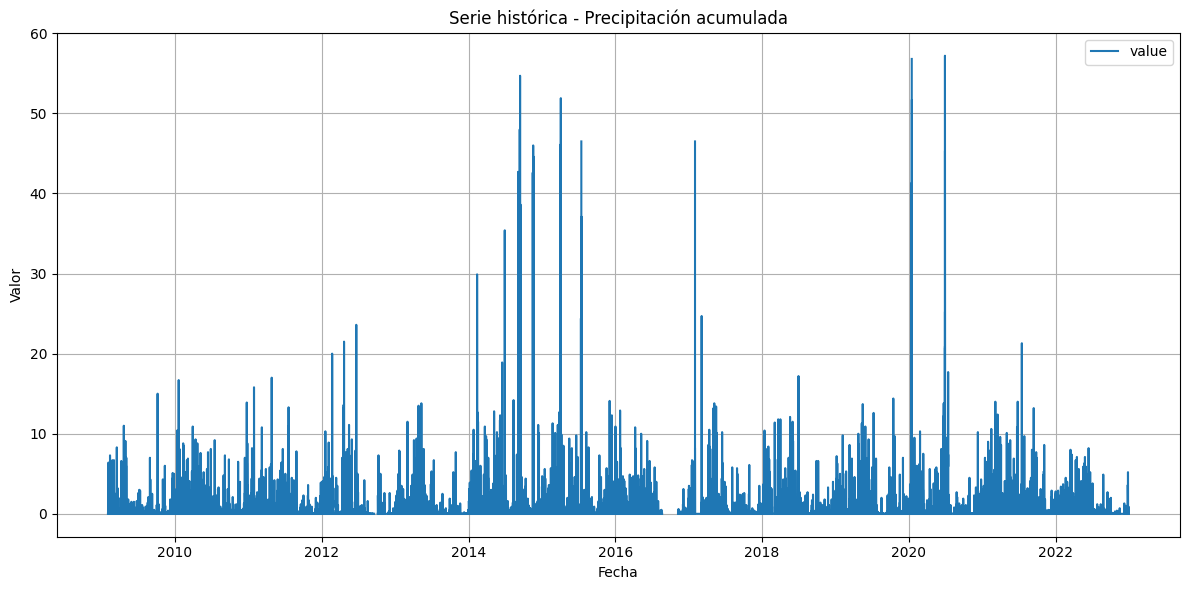

In [ ]:
from api_somo import APIClient, fetch_qf 
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Configuración del logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

api_url = "http://127.0.0.1:8000/database/functions/time-series/filter_date_serie/"
params = {
    "station_name": "tumaco",
    "variable_name": "Precipitación acumulada",
    "processing_level_name": "Control de calidad",
    "start_date": "2009-01-01",
    "end_date": "2023-12-31"
}

try:
    # 1. Solicitar y procesar los datos
    red_mpomm_serie, red_mpomm_metadata = APIClient.fetch_and_process_data(api_url, params)

    if not pd.api.types.is_datetime64_any_dtype(red_mpomm_serie.index):
        red_mpomm_serie.index = pd.to_datetime(red_mpomm_serie.index)

    if red_mpomm_serie.empty:
        raise ValueError("La serie histórica está vacía.")

    logger.info(f"Serie histórica descargada correctamente. Columnas: {red_mpomm_serie.columns.tolist()}")

except Exception as e:
    logger.error(f"Error al obtener la serie histórica: {e}")
    red_mpomm_serie = pd.DataFrame()  # para evitar errores en siguientes pasos

# --- PROCESAMIENTO: FILTRAR CALIDAD ---
if not red_mpomm_serie.empty:
    # QF: Solo valores con calidad 1 o 3 son aceptados
    red_mpomm_serie.loc[~red_mpomm_serie['qf'].isin([1, 3])] = np.nan
    red_mpomm_serie = red_mpomm_serie.drop(columns='qf')

    # Reporte de NaNs
    print('Reporte de datos NaN por columna:')
    print(red_mpomm_serie.isnull().sum())
    
    # --- GRAFICAR ---
    plt.figure(figsize=(12, 6))
    plt.plot(red_mpomm_serie, label=red_mpomm_serie.columns[0])
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.title('Serie histórica - Precipitación acumulada')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Mostrar primeras filas
    red_mpomm_serie

# Serie MSWEB

Reporte de datos NaN por columna:
precipitation    0
dtype: int64


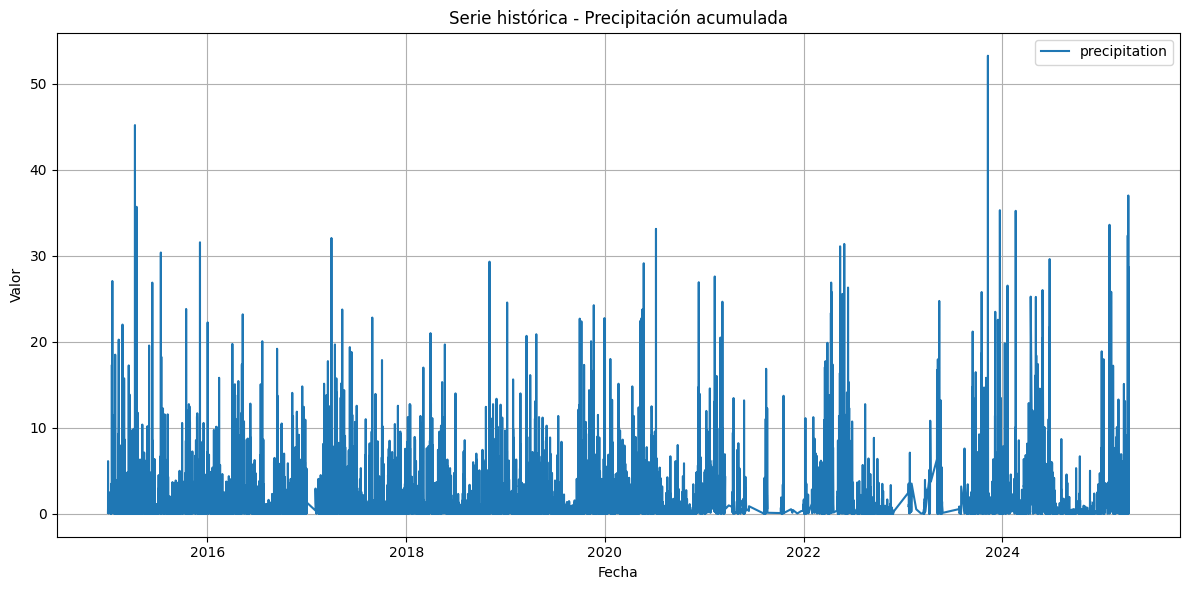

,precipitation
date,
2015-01-01 00:00:00,0.125000
2015-01-01 03:00:00,0.625000
2015-01-01 06:00:00,0.625000
2015-01-01 09:00:00,6.125000
2015-01-01 12:00:00,2.437500
...,...
2025-04-10 03:00:00,4.144755
2025-04-10 06:00:00,2.148014
2025-04-10 09:00:00,1.783330


In [9]:
import pandas as pd

# Cargar el CSV y parsear la columna de fecha como datetime
msweb_serie = pd.read_csv(
    r"D:\master BigData\01 proyecto final\datos\msweb\csv\precipitacion(1.82011, -78.72871).csv",
    parse_dates=['date'],   # reemplaza 'datetime' con el nombre real de tu columna de fecha
    index_col='date'        # establecer la columna como índice
)


# --- PROCESAMIENTO: FILTRAR CALIDAD ---
if not red_mpomm_serie.empty:
    # QF: Solo valores con calidad 1 o 3 son aceptados
    #msweb_serie.loc[~msweb_serie['qf'].isin([1, 3])] = np.nan
    #msweb_serie = msweb_serie.drop(columns='qf')

    # Reporte de NaNs
    print('Reporte de datos NaN por columna:')
    print(msweb_serie.isnull().sum())
    
    # --- GRAFICAR ---
    plt.figure(figsize=(12, 6))
    plt.plot(msweb_serie, label=msweb_serie.columns[0])
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.title('Serie histórica - Precipitación acumulada')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
msweb_serie



# Seerie IDEAM

Reporte de datos NaN por columna:
Valor    0
dtype: int64


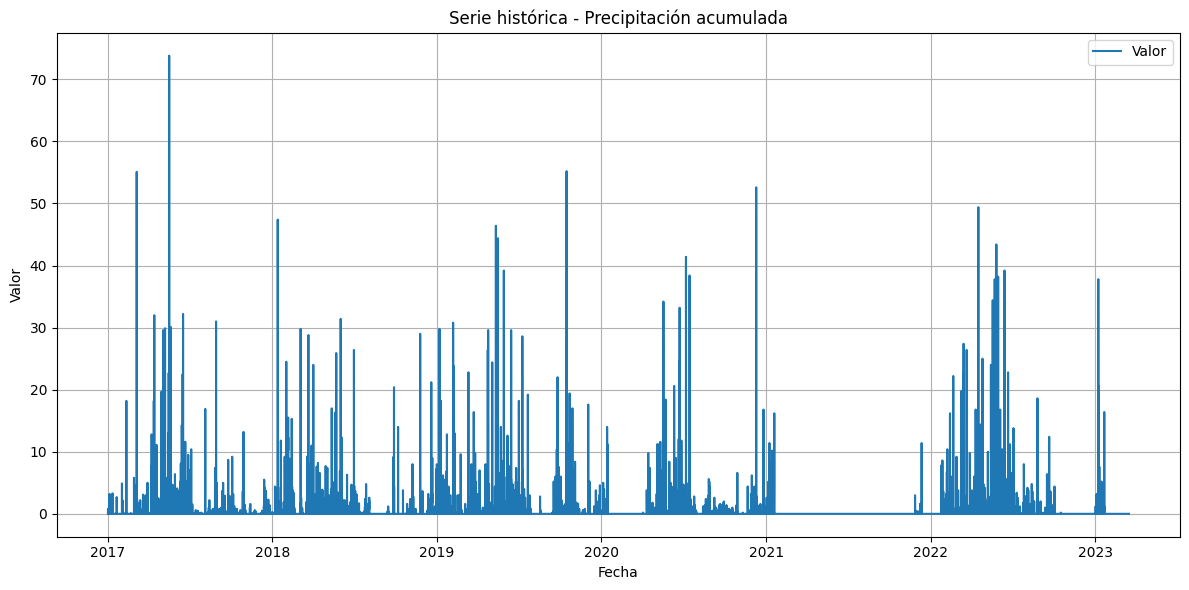

,Valor
Fecha,
2017-01-01 08:00:00,0.0
2017-01-01 09:00:00,0.0
2017-01-01 10:00:00,0.7
2017-01-01 11:00:00,0.0
2017-01-01 12:00:00,0.3
...,...
2023-03-17 01:00:00,0.0
2023-03-17 02:00:00,0.0
2023-03-17 03:00:00,0.0


In [10]:
import pandas as pd

# Cargar el CSV y parsear la columna de fecha como datetime
ideam_serie = pd.read_csv(
    r"D:\master BigData\01 proyecto final\datos\IDEAM_ST\prec\tumaco_-78,73-1,82.csv",
    parse_dates=['Fecha'],   # reemplaza 'datetime' con el nombre real de tu columna de fecha
    index_col='Fecha'        # establecer la columna como índice
)
ideam_serie = ideam_serie[['Valor']]

# --- PROCESAMIENTO: FILTRAR CALIDAD ---
if not ideam_serie.empty:
    # QF: Solo valores con calidad 1 o 3 son aceptados
    #ideam_serie.loc[~ideam_serie['qf'].isin([1, 3])] = np.nan
    #ideam_serie = ideam_serie.drop(columns='qf')

    # Reporte de NaNs
    print('Reporte de datos NaN por columna:')
    print(ideam_serie.isnull().sum())
    
    # --- GRAFICAR ---
    plt.figure(figsize=(12, 6))
    plt.plot(ideam_serie, label=ideam_serie.columns[0])
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.title('Serie histórica - Precipitación acumulada')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

ideam_serie


# Serie Chirps

Intentando conectar a MongoDB...
Conexión a MongoDB exitosa.
[]
Obteniendo documentos de la colección...
Se encontraron 60996 puntos. Convirtiendo a DataFrame...
Reporte de datos NaN por columna:
point_id
point_6    0
dtype: int64


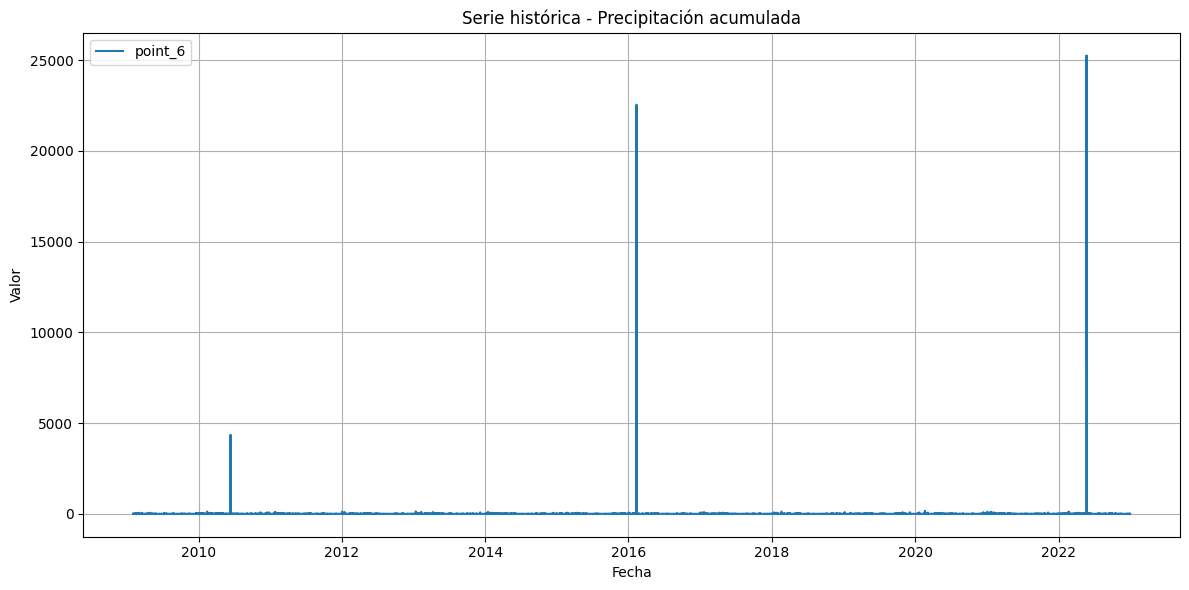

point_id,point_6
timestamp,
2009-02-01,0.000000
2009-02-02,0.000000
2009-02-03,29.260645
2009-02-04,0.000000
2009-02-05,0.000000
...,...
2022-12-28,7.627149
2022-12-29,0.000000
2022-12-30,11.136356


In [11]:
from pymongo import MongoClient
from pymongo.errors import ConnectionFailure, OperationFailure

try:
    # Conexión a MongoDB
    print("Intentando conectar a MongoDB...")
    client = MongoClient('localhost', 27017)  # Cambia los parámetros si es necesario
    print("Conexión a MongoDB exitosa.")

    # Selecciona la base de datos y la colección
    db = client['CHIRPS']
    collection = db['tumaco']

    print(client['EVC-SOMMO'].list_collection_names())  # Lista las colecciones de la base de datos


    # Consulta para obtener todos los documentos de la colección
    print("Obteniendo documentos de la colección...")
    data = collection.find()  # Esto devuelve un cursor iterable

    # Convertir el cursor a una lista
    data_list = list(data)

    if not data_list:
        print("No se encontraron documentos.")
    else:
        # Crear listas para almacenar los datos extraídos
        points = []
        timestamps = []

        # Recorrer los documentos y extraer los datos relevantes
        for document in data_list:
            timestamp = document.get('timestamp')  # Extrae el timestamp
            points_data = document.get('point_data', [])  # Extrae el array de puntos

            for point in points_data:
                point_dict = {
                    'point_id': point.get('point_id'),
                    'latitude': point.get('latitude'),
                    'longitude': point.get('longitude'),
                    'value': point.get('value'),
                    'timestamp': timestamp  # Incluir timestamp para cada punto
                }
                points.append(point_dict)

        # Convertir los puntos a un DataFrame
        print(f"Se encontraron {len(points)} puntos. Convirtiendo a DataFrame...")
        data_mongo_df = pd.DataFrame(points)

        # Si la colección tiene un campo '_id', lo eliminamos para evitar problemas
        if '_id' in data_mongo_df.columns:
            data_mongo_df = data_mongo_df.drop(columns=['_id'])
        
        # Filtrar los puntos deseados
        selected_points = ['point_6', 'point_10', 'point_12']
        data_mongo_df = data_mongo_df[data_mongo_df['point_id'].isin(selected_points)]
        

except ConnectionFailure as e:
    print(f"Error al conectar con MongoDB: {e}")
except OperationFailure as e:
    print(f"Error en la operación de MongoDB: {e}")
except Exception as e:
    print(f"Error inesperado: {e}")
    
# Crear la tabla pivotante con fecha como índice y cada punto como columna
series_chirps = data_mongo_df.pivot_table(index='timestamp', columns='point_id', values='value')
series_chirps.index = pd.to_datetime(series_chirps.index)
chirps_serie = series_chirps[['point_6']]

# --- PROCESAMIENTO: FILTRAR CALIDAD ---
if not chirps_serie.empty:
    # QF: Solo valores con calidad 1 o 3 son aceptados
    #chirps_serie.loc[~chirps_serie['qf'].isin([1, 3])] = np.nan
    #chirps_serie = chirps_serie.drop(columns='qf')

    # Reporte de NaNs
    print('Reporte de datos NaN por columna:')
    print(chirps_serie.isnull().sum())
    
    # --- GRAFICAR ---
    plt.figure(figsize=(12, 6))
    plt.plot(chirps_serie, label=chirps_serie.columns[0])
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.title('Serie histórica - Precipitación acumulada')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
chirps_serie